# Analyse tg-chat with nlp libs

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sb

import re
from collections import Counter

import seaborn as sns
pd.set_option('display.max_columns', None)

import spacy
import matplotlib.pyplot as plt
from os import path

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import json

import warnings
warnings.filterwarnings('ignore')

## First, let's open our dataset obtained by exporting the chat history

In [26]:
with open('result.json', encoding='utf-8') as f:
    data = json.load(f)

msgs = data['messages']
df = pd.DataFrame(msgs)

and select only the necessary columns from it

In [27]:
df_new = df.filter(items=['id', 'from', 'text', 'date'])
df_new["datetime"] = pd.to_datetime(df_new['date'])

df_new = df_new.loc[df_new['text'].str.len() > 2]
df_new

,id,from,text,date,datetime
0,95518,Пельмешек,"Ля, говорил об этой фиче ещё год назад, мол, в...",2023-06-27T07:12:38,2023-06-27 07:12:38
1,95519,Пельмешек,[Павел Дуров анонсировал функцию сторис в Tele...,2023-06-27T07:12:38,2023-06-27 07:12:38
3,95521,Иван овощепритон,Стреляй себе в голову,2023-06-27T11:37:46,2023-06-27 11:37:46
4,95522,Пельмешек,у меня она не болит,2023-06-27T11:41:15,2023-06-27 11:41:15
5,95523,Пельмешек,пока что,2023-06-27T11:41:18,2023-06-27 11:41:18
...,...,...,...,...,...
2055,97574,Иван овощепритон,Славимбо,2023-07-24T16:43:49,2023-07-24 16:43:49
2056,97575,Иван овощепритон,Славик бимбо,2023-07-24T16:43:56,2023-07-24 16:43:56
2058,97577,Иван овощепритон,Бля ебать он думает,2023-07-24T18:19:57,2023-07-24 18:19:57
2063,97582,Dagot Ur ✙,А как же презумпция невиновности,2023-07-25T11:04:22,2023-07-25 11:04:22


# Data analysis


In [28]:
#Function for counting the number of words in one message
def count_words(text):
    if isinstance(text, str):
        return len(text.split())
    else:
        return 0


df_new["word_count"] = df_new["text"].apply(count_words)
df_new = df_new.drop(['date'], axis=1)

In [5]:
df_new.head()

,id,from,text,datetime,word_count
0,95518,Пельмешек,"Ля, говорил об этой фиче ещё год назад, мол, в...",2023-06-27 07:12:38,16
1,95519,Пельмешек,[Павел Дуров анонсировал функцию сторис в Tele...,2023-06-27 07:12:38,0
3,95521,Иван овощепритон,Стреляй себе в голову,2023-06-27 11:37:46,4
4,95522,Пельмешек,у меня она не болит,2023-06-27 11:41:15,5
5,95523,Пельмешек,пока что,2023-06-27 11:41:18,2


Let's see which user wrote how many messages

In [6]:
message_count_per_user = df_new['from'].value_counts()
message_count_per_user

Ілля                438
Андрій              417
Иван овощепритон    372
Пельмешек           345
Миша Олизько         83
Dagot Ur ✙           42
Crocodile 🐊          39
Name: from, dtype: int64

Let's visualize this as a barplot graph

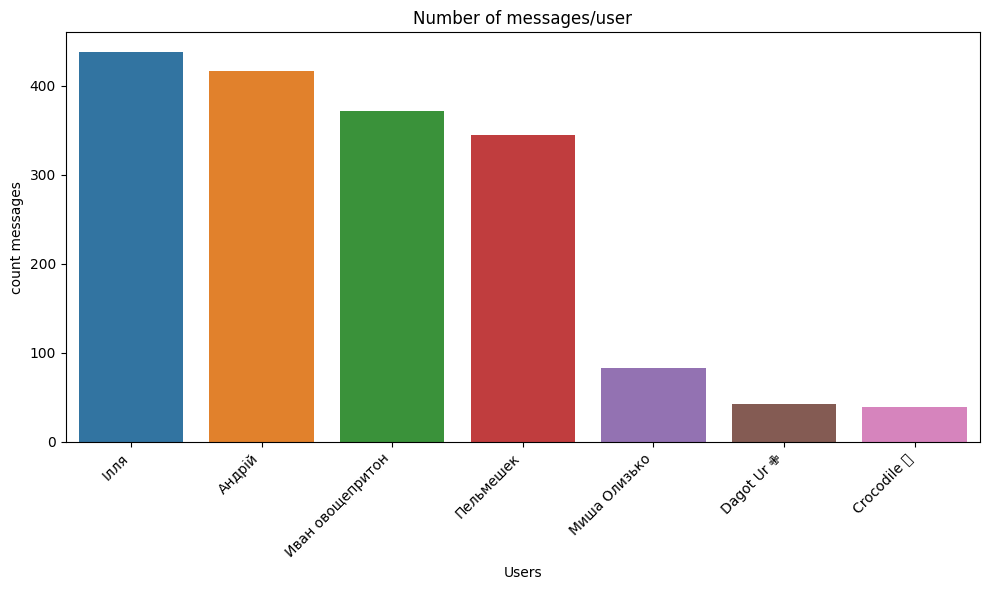

In [7]:
plt.figure(figsize=(10, 6))
sns.barplot(x=message_count_per_user.index, y=message_count_per_user.values)
plt.xlabel("Users")
plt.ylabel("count messages")
plt.title("Number of messages/user")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Pie chart visualization

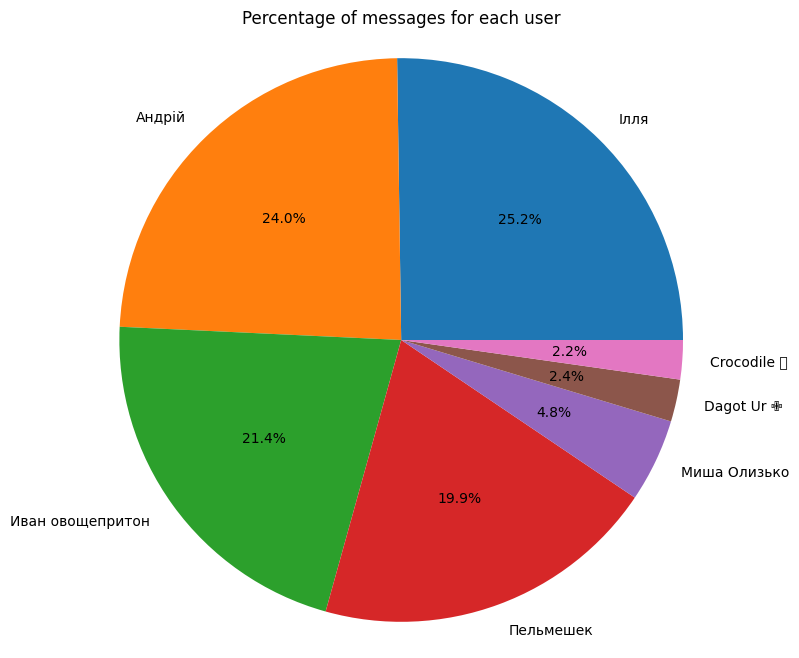

In [8]:
plt.figure(figsize=(8, 8))
plt.pie(message_count_per_user.values, labels=message_count_per_user.index, autopct="%1.1f%%")
plt.title("Percentage of messages for each user")
plt.axis("equal")
plt.show()

### Now let's calculate how many words on average a user sends per 1 message

In [9]:
# Group the data by sender and use the function to calculate the total number of words in all messages
word_count_per_user = df_new.groupby('from')['text'].apply(lambda x: x.str.split().str.len().sum())
message_count_per_user = df_new['from'].value_counts()


for user in word_count_per_user.index:
    word_count = word_count_per_user[user]  # Total number of words for the current sender
    message_count = message_count_per_user[user]

    average_words_per_message = word_count / message_count if message_count > 0 else 0

    print(f"{user} sent {word_count} words, average {average_words_per_message:.3f} per message")

Crocodile 🐊 sent 218.0 words, average 5.590 per message
Dagot Ur ✙ sent 167.0 words, average 3.976 per message
Ілля sent 1658.0 words, average 3.785 per message
Андрій sent 3088.0 words, average 7.405 per message
Иван овощепритон sent 1416.0 words, average 3.806 per message
Миша Олизько sent 599.0 words, average 7.217 per message
Пельмешек sent 1918.0 words, average 5.559 per message


Here we will delete one message for one user, which prevents the corrected result from being output next

In [29]:
df_new.query('`from` == "Пельмешек" and text.str.contains("РАСТ")', engine='python')['text'].index #1351

Int64Index([1351], dtype='int64')

In [30]:
df_new.drop(1351, inplace=True)

## Now let's display the frequent words from all the messages

In [12]:
text_df = df_new.text.dropna()
text = " ".join(review for review in df_new.text.dropna() if review is not None and type(review) == str)
print ("There are {} words in all the messages.".format(len(text)))

There are 51738 words in all the messages.


Since our dataset completely contains Russian words, it is necessary to specify Russian as stop words. For English such things as TFIDF and LDA are supported automatically, for all others stop words should be specified in a similar way

In [13]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
russian_stopwords = set(stopwords.words('russian'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


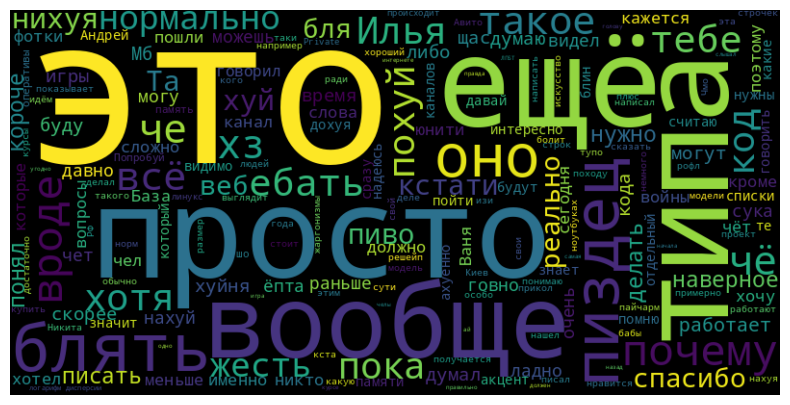

In [14]:
stopwords = set(STOPWORDS)
stopwords.update(russian_stopwords)
wordcloud = WordCloud(width=800, height=400,stopwords=stopwords, background_color="black").generate(text)
# Display the generated image:
plt.figure( figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## As you can see, these messages are full of obscene words and words of parasites, which is normal for live and informal communication between people

## Now a bit of statistical information. Let's display the chat activity by day

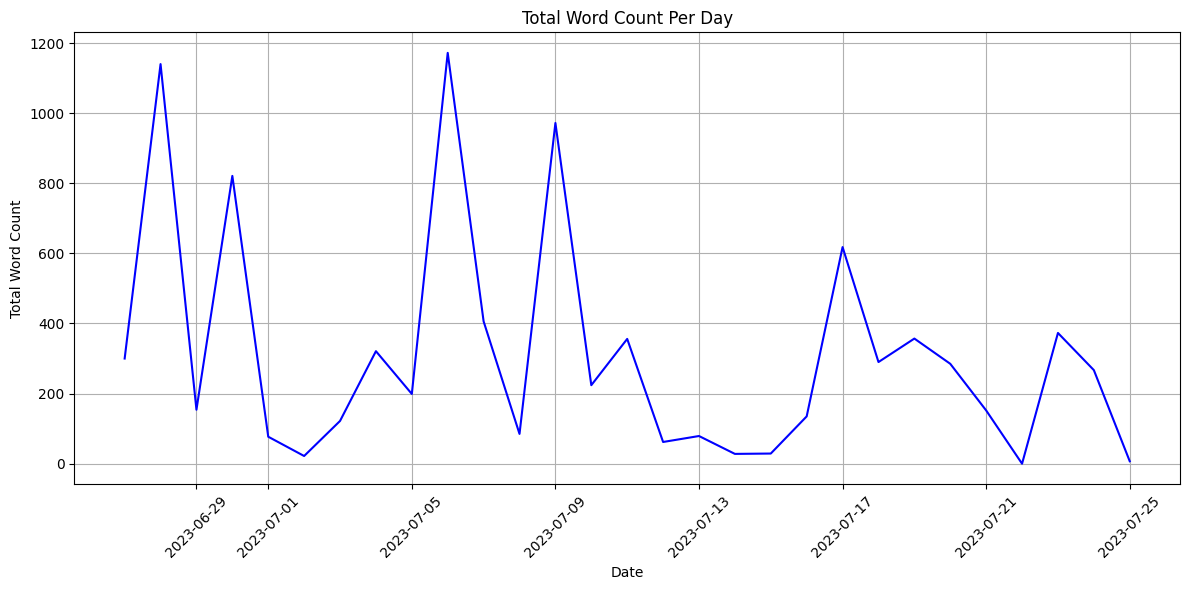

In [15]:
daily_counts = df_new.resample("D", on="datetime").sum()["word_count"]

plt.figure(figsize=(12, 6))
plt.plot(daily_counts.index, daily_counts.values, color='b')
plt.xlabel("Date")
plt.ylabel("Total Word Count")
plt.title("Total Word Count Per Day")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

## Let's also display the activity by hour

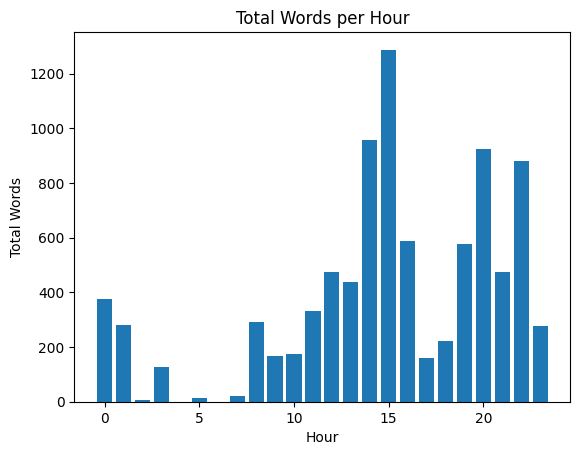

In [16]:
hourly_word_count_df = df_new.groupby(df_new['datetime'].dt.hour)['word_count'].sum().reset_index()

hourly_word_count_df.rename(columns={"datetime": "hour", "word_count": "total_words"}, inplace=True)
plt.bar(hourly_word_count_df['hour'], hourly_word_count_df['total_words'])

plt.title('Total Words per Hour')
plt.xlabel('Hour')
plt.ylabel('Total Words')

plt.show()

## And exactly the same but with the indication of user activity

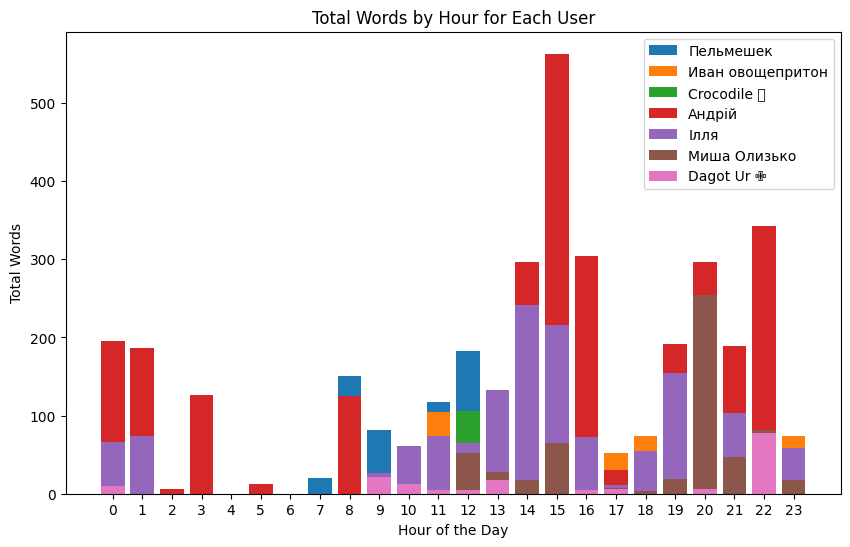

In [17]:
hourly_user_word_count_df = df_new.groupby([df_new['datetime'].dt.hour, 'from'])['word_count'].sum().reset_index()
hourly_user_word_count_df.rename(columns={"datetime": "hour", "word_count": "total_words"}, inplace=True)

plt.figure(figsize=(10, 6))
for user in df_new['from'].unique():
    user_data = hourly_user_word_count_df[hourly_user_word_count_df['from'] == user]
    plt.bar(user_data['hour'], user_data['total_words'], label=user)

plt.xlabel("Hour of the Day")
plt.ylabel("Total Words")
plt.title("Total Words by Hour for Each User")
plt.xticks(range(24))
plt.legend()
plt.show()

## Now analyze the activity by day of the week in the form of a polar diagram

In [31]:
df_new['weekday'] = df_new['datetime'].dt.weekday

# Group the data by day of the week and calculate the total number of words
weekday_word_count_df = df_new.groupby('weekday')['word_count'].sum().reset_index()

# Rename columns for clarity
weekday_word_count_df.rename(columns={"weekday": "day_of_week", "word_count": "total_words"}, inplace=True)

# Convert numeric values of the day of the week to text format
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_word_count_df['day_of_week'] = weekday_word_count_df['day_of_week'].map(lambda x: day_names[x])

print(weekday_word_count_df)

  day_of_week  total_words
0      Monday         1231
1     Tuesday         1274
2   Wednesday         1758
3    Thursday         1690
4      Friday         1407
5    Saturday          191
6      Sunday         1502


In [19]:
import plotly.graph_objects as go

day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

fig = go.Figure()
fig.add_trace(go.Scatterpolar(
    r=weekday_word_count_df['total_words'],
    theta=day_names,
    mode='lines',
    line_shape='linear',
    fill='toself'
))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, weekday_word_count_df['total_words'].max() + 100]  # Increase the range for the radius axis
        )
    ),
    showlegend=False,
    title='Total Words by Day of Week',
)

fig.show()

## Same thing, but on a per-user basis

In [32]:
weekday_user_word_count_df = df_new.groupby(['from', df_new['datetime'].dt.weekday])['word_count'].sum().reset_index()
weekday_user_word_count_df.rename(columns={"datetime": "day_of_week", "word_count": "total_words"}, inplace=True)

day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_user_word_count_df['day_of_week'] = weekday_user_word_count_df['day_of_week'].map(lambda x: day_names[x])

fig = go.Figure()
for user in df_new['from'].unique():
    user_data = weekday_user_word_count_df[weekday_user_word_count_df['from'] == user]
    fig.add_trace(go.Scatterpolar(
        r=user_data['total_words'],
        theta=day_names,
        mode='lines',
        line_shape='linear',
        fill='toself',
        name=user  # The name of the line will be the user name
    ))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, weekday_user_word_count_df['total_words'].max() + 100]
        )
    ),
    showlegend=True,
    title='Total Words by Day of Week for Each User',
)
fig.show()

## Now let's derive the typical words for each user.

In this situation, I used bigrams to find the most frequent links for each user

In [33]:
from nltk.util import ngrams
nltk.download('punkt')

def get_typical_bigram(user_text):
    # Tokenize the text and create bigrams
    tokens = nltk.word_tokenize(user_text)
    bigrams = ngrams(tokens, 2)
    # Counting the frequency of bigrams
    bigram_freq = Counter(bigrams)
    # We get the most frequent bigrams
    typical_bigram = bigram_freq.most_common(1)
    return typical_bigram[0][0]

# preprocessing function
def preprocess_text(text):
    text = text.lower()

    text = re.sub(r'[^\w\s]', '', text)

    return text

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [38]:
# Delete all forwarded messages
df_new = df_new[df_new['text'].apply(lambda x: isinstance(x, str))]
df_new.reset_index(drop=True, inplace=True)

In [37]:
typical_sentences_df = pd.DataFrame(columns=['from', 'typical_sentence'])

grouped_by_user = df_new.groupby('from')



for user, user_data in grouped_by_user:
    user_text = ' '.join(user_data['text'].dropna().astype(str).apply(preprocess_text))  # Merge the user's text messages
    typical_bigram = get_typical_bigram(user_text)
    typical_sentence = ' '.join(typical_bigram)  # Combine the bigram into a sentence
    typical_sentences_df = typical_sentences_df.append({'from': user, 'typical_sentence': typical_sentence}, ignore_index=True)

typical_sentences_df

,from,typical_sentence
0,Crocodile 🐊,на авито
1,Dagot Ur ✙,то ли
2,Ілля,да я
3,Андрій,у меня
4,Иван овощепритон,или веб
5,Миша Олизько,считаю что
6,Пельмешек,у меня


In [42]:
!pip install stop-words

## Since this is a live chat, people chat about different topics. In order to find out how many topics are supported by users, it is necessary to model them. To do this, let's write the following code

In [45]:
import gensim
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import NMF
from nltk.corpus import stopwords
from stop_words import get_stop_words
stoplist = get_stop_words('russian')

Maximum coherence value for Пельмешек-  2


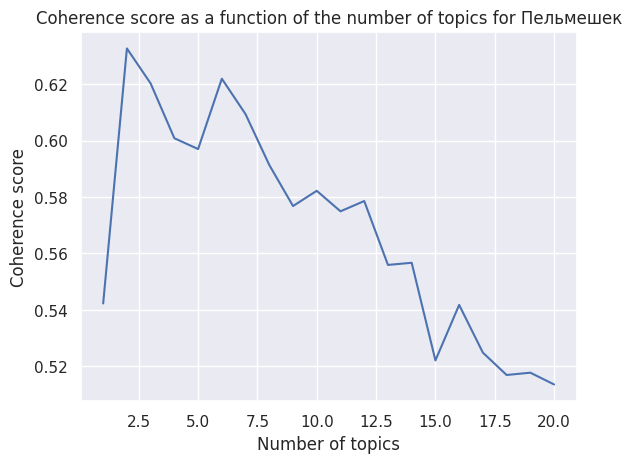

Maximum coherence value for Иван овощепритон-  1


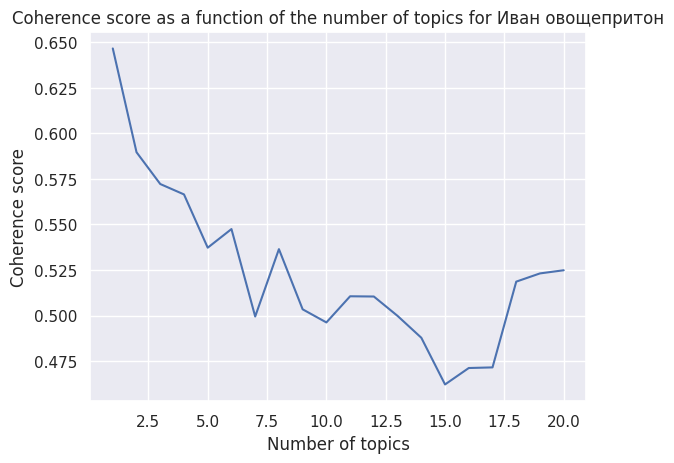

Maximum coherence value for Crocodile 🐊-  15


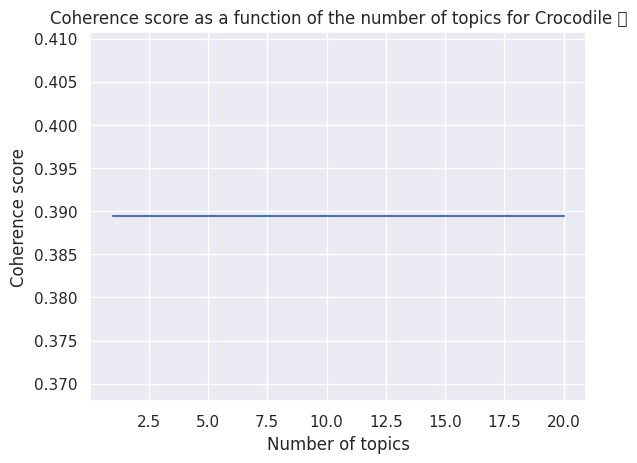

Maximum coherence value for Андрій-  5


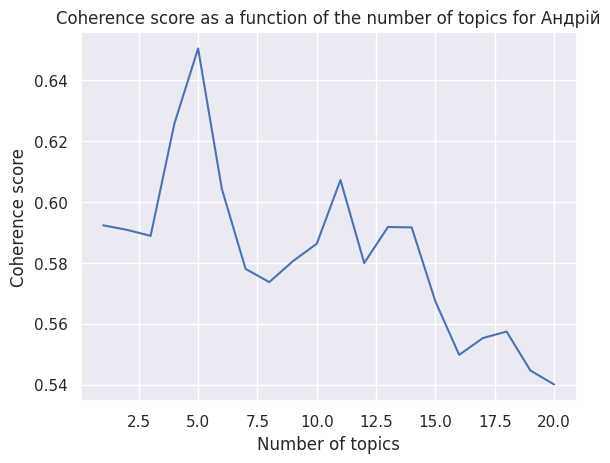

Maximum coherence value for Ілля-  2


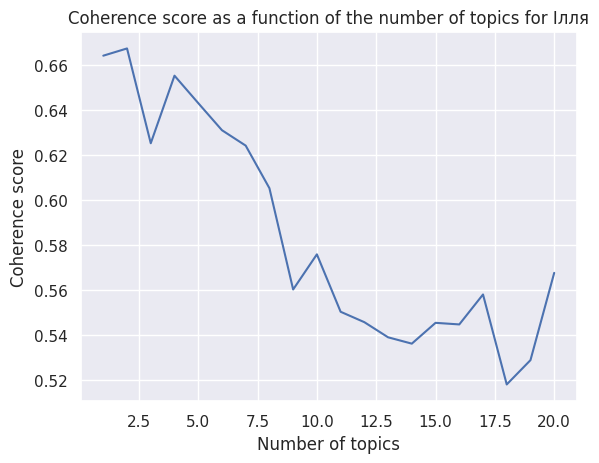

Maximum coherence value for Миша Олизько-  6


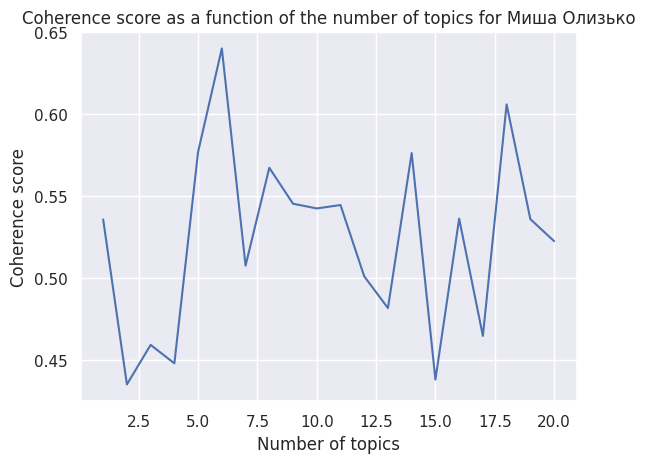

Maximum coherence value for Dagot Ur ✙-  1


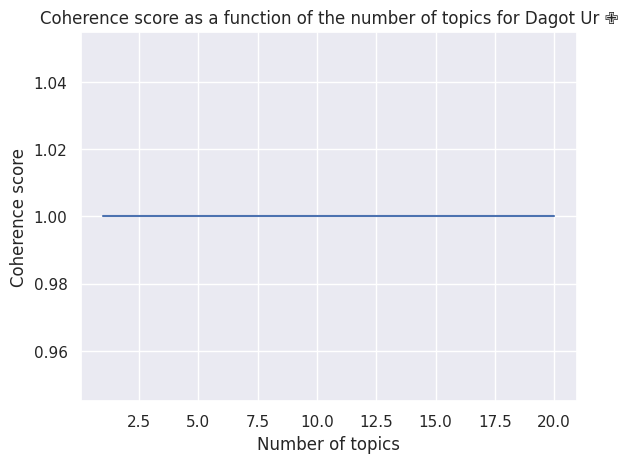

<Figure size 640x480 with 0 Axes>

In [46]:
min_topics = 1
max_topics = 20

topics_for_users = {}

for user in df_new['from'].unique():
    user_data = df_new.loc[df_new['from'] == user]

    text_tokens = [text.split() for text in user_data['text']]
    dictionary = corpora.Dictionary(text_tokens)

    vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words=stoplist)
    X = vectorizer.fit_transform(user_data['text'])

    coherence_scores = []

    for n_topics in range(min_topics, max_topics+1):
        lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=1706, n_jobs=-1)
        lda_model.fit(X)
        doc_topic_dist = lda_model.transform(X)
        topic_word_dist = lda_model.components_ / lda_model.components_.sum(axis=1)[:, np.newaxis]
        top_words = [[vectorizer.get_feature_names_out()[j] for j in topic.argsort()[:-11:-1]] for topic in topic_word_dist]
        cm = CoherenceModel(topics=top_words, texts=text_tokens, dictionary=dictionary, coherence='c_v')
        coherence_scores.append(cm.get_coherence())

    max_index = np.argmax(coherence_scores)
    max_index_plus_one = max_index + 1
    topics_for_users[user] = max_index_plus_one

    print(f"Maximum coherence value for {user}- ", max_index_plus_one)

    sns.set()
    plt.plot(range(min_topics, n_topics+1), coherence_scores)
    plt.xlabel('Number of topics')
    plt.ylabel('Coherence score')
    plt.title(f'Coherence score as a function of the number of topics for {user}')
    plt.show()
    plt.clf()

In [47]:
#small correction for the user
topics_for_users['Crocodile 🐊'] = 1
topics_for_users

{'Пельмешек': 2,
 'Иван овощепритон': 1,
 'Crocodile 🐊': 1,
 'Андрій': 5,
 'Ілля': 2,
 'Миша Олизько': 6,
 'Dagot Ur ✙': 1}

## Modeling the words for each topic for the user

In [48]:
for user, n_topics in topics_for_users.items():
    user_data = df_new.loc[df_new['from'] == user]
    tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words=stoplist)
    dtm = tfidf.fit_transform(user_data['text'])

    nmf_model = NMF(n_components=n_topics, random_state=1706)
    nmf_model.fit(dtm)

    for index, topic in enumerate(nmf_model.components_):
        print(f"For user {user}")
        print(f'THE TOP 5 WORDS FOR TOPIC #{index}')
        print([tfidf.get_feature_names_out()[i] for i in topic.argsort()[-5:]])
        print('\n')

For user Пельмешек
THE TOP 5 WORDS FOR TOPIC #0
['стоит', 'нашел', 'рф', 'вообще', 'типа']


For user Пельмешек
THE TOP 5 WORDS FOR TOPIC #1
['чёт', 'должен', 'пиздец', 'вопросы', 'вроде']


For user Иван овощепритон
THE TOP 5 WORDS FOR TOPIC #0
['андроид', 'работает', 'че', 'ёпта', 'блять']


For user Crocodile 🐊
THE TOP 5 WORDS FOR TOPIC #0
['видел', 'чвк', '2д', 'авито']


For user Андрій
THE TOP 5 WORDS FOR TOPIC #0
['погоди', 'получается', 'блять', 'делать', 'чё']


For user Андрій
THE TOP 5 WORDS FOR TOPIC #1
['видел', 'работа', 'работает', 'илья', 'вообще']


For user Андрій
THE TOP 5 WORDS FOR TOPIC #2
['предлагаю', 'пить', 'илья', 'пошли', 'пиво']


For user Андрій
THE TOP 5 WORDS FOR TOPIC #3
['код', 'норм', 'вроде', 'всякие', 'хз']


For user Андрій
THE TOP 5 WORDS FOR TOPIC #4
['скорее', 'писать', 'нормально', 'придётся', 'жесть']


For user Ілля
THE TOP 5 WORDS FOR TOPIC #0
['дохуя', '200', 'ява', 'писать', 'типа']


For user Ілля
THE TOP 5 WORDS FOR TOPIC #1
['делать', 'х

# MODELS

We now use the trained LLM model to define semantic analysis. We use it as a perfect matcher, even though it is not

In [49]:
!pip install datasets evaluate transformers[sentencepiece]

In [50]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
from tensorflow.keras import losses

In [51]:
from transformers import pipeline
classifier_ru = pipeline("sentiment-analysis", model = 'seara/rubert-tiny2-russian-sentiment')

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [52]:
def compute_sentiment(text):
    if isinstance(text, list):
        text = text[0] if text else ""
    # print(text)
    sentiment_dict = classifier_ru(text)[0]
    return sentiment_dict['label'], sentiment_dict['score']

In [53]:
%%time
# Now create 2 new columns
df_new[['label', 'score']] = df_new['text'].apply(compute_sentiment).apply(pd.Series)

CPU times: user 16.1 s, sys: 50.9 ms, total: 16.2 s
Wall time: 30.4 s


In [54]:
df_new.head()

,id,from,text,datetime,word_count,weekday,label,score
0,95518,Пельмешек,"Ля, говорил об этой фиче ещё год назад, мол, в...",2023-06-27 07:12:38,16,1,neutral,0.632405
1,95521,Иван овощепритон,Стреляй себе в голову,2023-06-27 11:37:46,4,1,neutral,0.843735
2,95522,Пельмешек,у меня она не болит,2023-06-27 11:41:15,5,1,neutral,0.608578
3,95523,Пельмешек,пока что,2023-06-27 11:41:18,2,1,neutral,0.775938
4,95524,Иван овощепритон,Не болит не болит,2023-06-27 11:41:29,4,1,neutral,0.597569


## Let's write a simple model for semantic analysis using tensorflow

In [55]:
X, y = df_new['text'], df_new['label']

In [56]:
import re
import string

def preprocess_text(text):
    text = text.lower()

    text = re.sub(r'[^\w\s]', '', text)

    return text

label_mapping = {label: idx for idx, label in enumerate(y.unique())}


In [57]:
X = df_new['text'].apply(preprocess_text)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_new['label'])

In [58]:
X_train, X_test, y_train, y_test = train_test_split(df_new['text'], y, test_size=0.2, random_state=1706)

In [59]:
# Initialization of Tokenizer for text vectorization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Don't forget the paddling
max_length = max(len(sequence) for sequence in tokenizer.texts_to_sequences(df_new['text']))
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

In [60]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=64, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 121, 64)           189696    
                                                                 
 conv1d (Conv1D)             (None, 117, 128)          41088     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 29, 128)          0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                        

In [61]:

# model training
epochs = 5
batch_size = 64
history = model.fit(X_train_padded, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

Epoch 1/5
17/17 [==============================] - 11s 308ms/step - loss: 0.8404 - accuracy: 0.7925 - val_loss: 0.5667 - val_accuracy: 0.8358
Epoch 2/5
17/17 [==============================] - 3s 155ms/step - loss: 0.6380 - accuracy: 0.8037 - val_loss: 0.5505 - val_accuracy: 0.8358
Epoch 3/5
17/17 [==============================] - 2s 100ms/step - loss: 0.6363 - accuracy: 0.8037 - val_loss: 0.5436 - val_accuracy: 0.8358
Epoch 4/5
17/17 [==============================] - 2s 105ms/step - loss: 0.6334 - accuracy: 0.8037 - val_loss: 0.5631 - val_accuracy: 0.8358
Epoch 5/5
17/17 [==============================] - 2s 126ms/step - loss: 0.6249 - accuracy: 0.8037 - val_loss: 0.5514 - val_accuracy: 0.8358


## output the results of the model

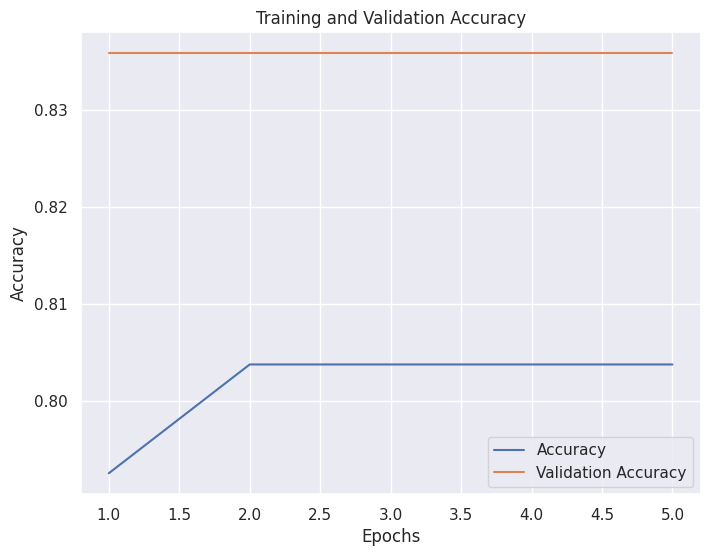

In [62]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 1), accuracy, label='Accuracy')
plt.plot(range(1, epochs + 1), val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

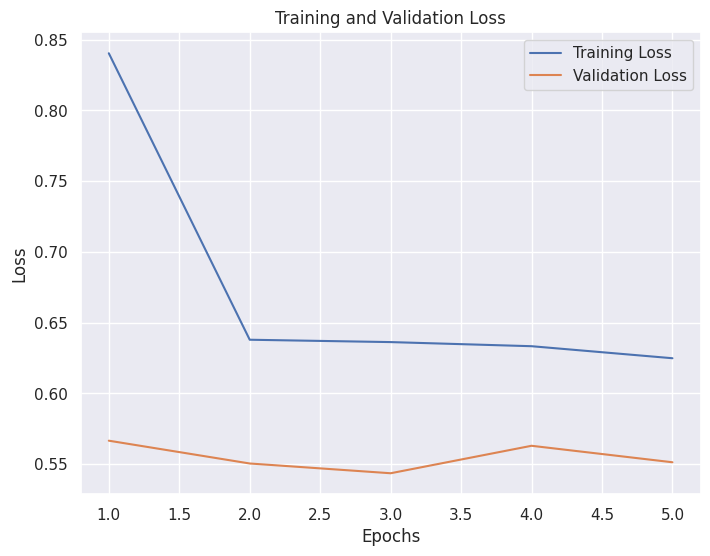

In [63]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 1), loss, label='Training Loss')
plt.plot(range(1, epochs + 1), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# The same but for classic models

In [64]:
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier

In [65]:
X = df_new['text'].apply(preprocess_text)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_new['label'])

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1706)
vectorizer = TfidfVectorizer(max_features=10000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [67]:
clf = XGBClassifier()
clf.fit(X_train_vec, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [68]:
y_pred = clf.predict(X_test_vec)

# Model performance evaluation
accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy:", accuracy)

Test accuracy: 0.8059701492537313


In [69]:
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

    negative       0.83      0.36      0.50        53
     neutral       0.82      0.97      0.89       257
    positive       0.20      0.08      0.11        25

    accuracy                           0.81       335
   macro avg       0.62      0.47      0.50       335
weighted avg       0.78      0.81      0.77       335



In [70]:
df_new

,id,from,text,datetime,word_count,weekday,label,score
0,95518,Пельмешек,"Ля, говорил об этой фиче ещё год назад, мол, в...",2023-06-27 07:12:38,16,1,neutral,0.632405
1,95521,Иван овощепритон,Стреляй себе в голову,2023-06-27 11:37:46,4,1,neutral,0.843735
2,95522,Пельмешек,у меня она не болит,2023-06-27 11:41:15,5,1,neutral,0.608578
3,95523,Пельмешек,пока что,2023-06-27 11:41:18,2,1,neutral,0.775938
4,95524,Иван овощепритон,Не болит не болит,2023-06-27 11:41:29,4,1,neutral,0.597569
...,...,...,...,...,...,...,...,...
1668,97574,Иван овощепритон,Славимбо,2023-07-24 16:43:49,1,0,positive,0.867155
1669,97575,Иван овощепритон,Славик бимбо,2023-07-24 16:43:56,2,0,positive,0.574893
1670,97577,Иван овощепритон,Бля ебать он думает,2023-07-24 18:19:57,4,0,negative,0.773360
1671,97582,Dagot Ur ✙,А как же презумпция невиновности,2023-07-25 11:04:22,5,1,negative,0.619159


## save the dataset for future tasks

In [71]:
df_new.to_csv('tg_month_bm.csv', index=False)